##  Here, is a second-order ordinary differential equation- an RLC circuit

 See the following blog post: https://towardsdatascience.com/inverse-physics-informed-neural-net-3b636efeb37e.


## Problem description

We want to find the current flow in a series RLC circuit described by the equation 
<br>
<br>
$$
L \dfrac{d^2 i}{d t^2} + R \dfrac{d i}{d t} + \dfrac{1}{C} i = 0~.~~~~~~~~~~~~~~~~~~~~~~(1)
$$
<br>

A switch in series with the circuit elements is initially left open, the capacitor is charged to V$_{0}$ volts, and then the switch is closed at $t$ = 0, leading to the initial conditions:

$$
i(0) = 0~~,~~\dfrac{d i}{d t} (0) = \dfrac{V_0}{L}~.~~~~~~~~~~~~~~~~~~~~~~~~(2)
$$
 
<br>
<br>
We will solve the problem in three different response regimes. If all other parameters remain fixed, the response regime can be chosen by choosing the appropriate value of resistance, $R$. 
<br>
<br>
<br>
1. The under-damped response regime, where:
$$
\dfrac{1}{\sqrt{LC}} > \dfrac{R}{2L}~.~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~(3)
$$
<br>
When $R$ = 1.2 ohms, $L$ = 1.5, henries, $C$ = 0.3 farads and V$_{0}$ = 12.0 volts, the exact solution is:

$$
i(t) = 5.57 e^{-0.4t} \sin(1.44 t)~.~~~~~~~~~~~~~~~~~~~~~~~~(4)
$$
<br>
<br>
<br>
2. The critically-damped response regime, where
$$
\dfrac{1}{\sqrt{LC}} = \dfrac{R}{2L}~.~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~(5)
$$
<br>
When $R$ = 4.47 ohms, $L$ = 1.5, henries, $C$ = 0.3 farads and V$_{0}$ = 12.0 volts, the exact solution is:

$$
i(t) = 8.0 t e^{-1.49t}~.~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~(6)
$$

<br>
<br>
<br>
3. The over-damped response regime, where
$$
\dfrac{1}{\sqrt{LC}} < \dfrac{R}{2L}~.~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~(7)
$$
<br>
When $R$ = 6.0 ohms, $L$ = 1.5, henries, $C$ = 0.3 farads and V$_{0}$ = 12.0 volts, the exact solution is:
<br>

$$
i(t) = 3.0 ( e^{-0.67t} - e^{-3.33t})~.~~~~~~~~~~~~~~~~~~~~~~~~~~~~(8)
$$
<br>
<br>
<br>



## Solution overview

> First, we train a standard neural network to interpolate a small part of the solution, using some observed training points from the analytical (ideal) solution.

> Then, we train a PINN to extrapolate the full solution outside of the training points.


In [257]:
# Anaconda environment to use on Macbook - NewPy38
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
%matplotlib notebook
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

### Define a class to create a PyTorch neural network. User specifies number of inputs, outputs, hidden layers and nodes in each hidden layer. In this example there is only one input - time - and one output - current. 

In [258]:
class FCN(nn.Module):
    """ Defines a fully connected network. 
    
    Note the use of the Tanh() activation function, which works pretty well.  I tried using Relu()
    and the PINN results were terrible.  This is because the first derivative of the ReLu() is a
    constant, while its second derivative is zero, which means the gradients will vanish. 
    """
    
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        # Here is the input layer that connects to the first hidden layer:
        self.fcs = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN), activation()])
        # Here are the hidden layers:
        self.fch = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), 
                                activation()]) for _ in range(N_LAYERS-1)])
        # Here is the output layer that connects to the last hidden layer:
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

## Analytic solution visualization

> Current $vs.$ time in the various regimes.  
### Here, the user selects which regime to analyze, and we plot the ideal solution, as well as the points to be used for prediction using a neural network.

There are 20 training points.


<IPython.core.display.Javascript object>


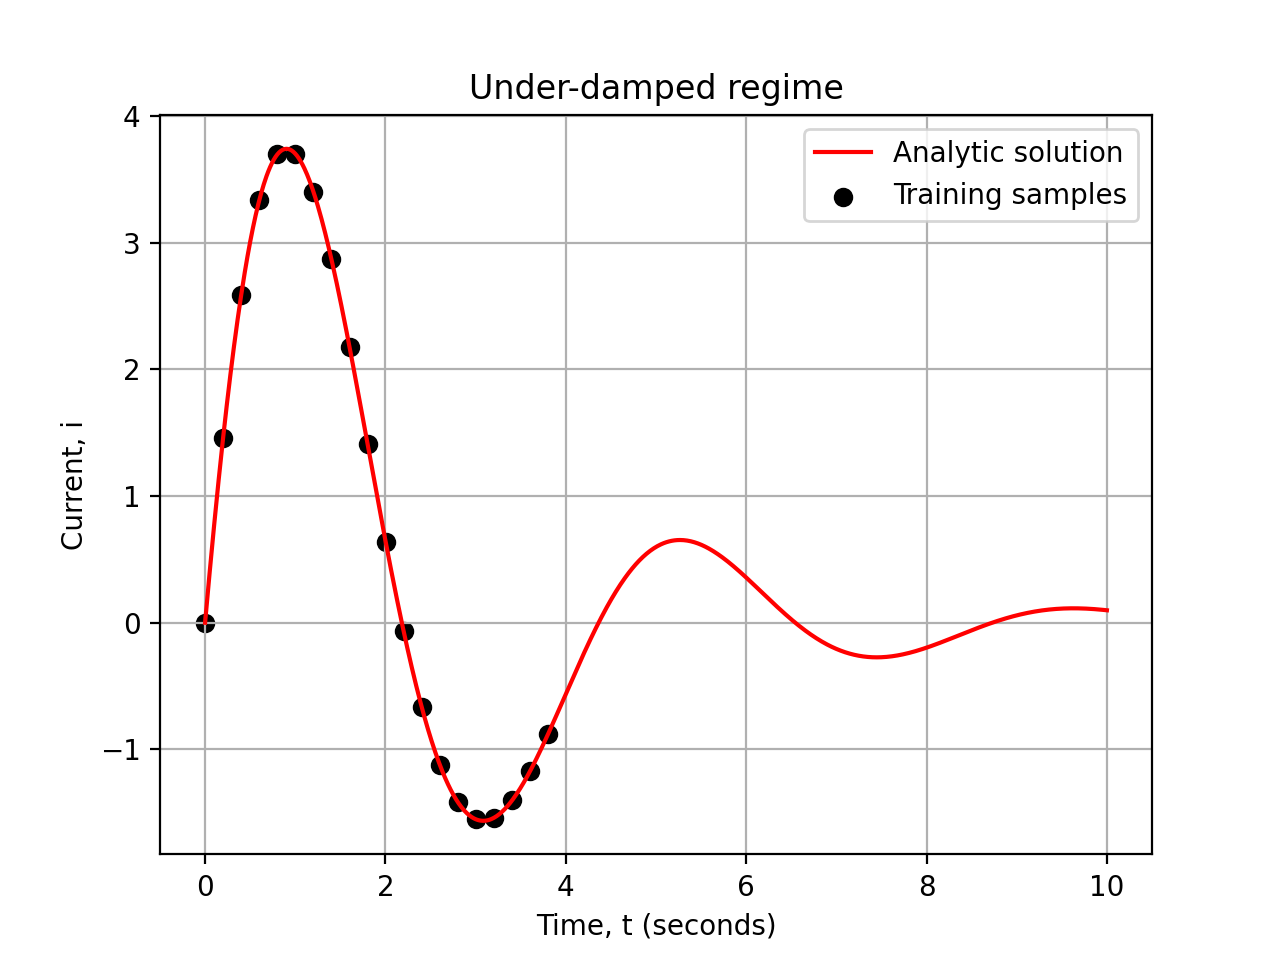

In [266]:
# Pick one of the three regimes by choosing the appropriate index - 
# 0: under-damped
# 1: critically-damped
# 2: over-damped

# We will also need the R, L, and C component values for the PINN

index = 0   # Viable choices are 0, 1, or 2 only
if ((index < 0) | (index > 2)):   # Default will be under-damped
    index = 0
regimes = ["under", "critical", "over"]
regime = regimes[index]

# There are 1000 time samples between 0 and 10 seconds
time_start, time_stop = 0.0, 10.0
t = torch.linspace(time_start, time_stop, 1000).view(-1,1)

# Calculate the under-damped response
if regime == "under":
    model_i = 5.57 * torch.exp(-0.4*t) * torch.sin(1.44*t)
    L, R, C, V0 = 1.2, 1.5, 0.3, 12.0
    regime = "Under-damped regime"

# Calculate the critically-damped response
if regime == "critical":
    model_i = 8.0 * t * torch.exp(-1.49*t)
    L, R, C, V0 = 1.2, 4.47, 0.3, 12.0
    regime = "Critically-damped regime"

# Calculate the over-damped response
if regime == "over":
    model_i = 3.0 * (torch.exp(-0.67*t) - torch.exp(-3.33*t))
    L, R, C, V0 = 1.2, 6.0, 0.3, 12.0
    regime = "Over-damped regime"


# Grab some analytically-calculated points - these are our targets for training the neural network.
# We will pretend later these are measurements. 
# We take 10 - 20 data points from the first 400 points which spans the first 400/1000 = 4.0 seconds.
step_size = 20  # Choose step size of about 20 or so - too big is no good
stop_pnt = 400
t_data = t[0:stop_pnt:int(step_size)]
i_data = model_i[0:stop_pnt:int(step_size)]
print(f'There are {int(stop_pnt/step_size)} training points.')

plt.figure()
plt.plot(t, model_i, "r-", label="Analytic solution")
plt.scatter(t_data, i_data, color="black", label="Training samples")
plt.xlabel('Time, t (seconds)')
plt.ylabel('Current, i')
plt.title(regime)
plt.grid()
plt.legend()
plt.show();

## Neural network training of select data points from the analytic solution

> Here, train a neural network to fit the training samples.  The default neural network has 3 layers with 32 nodes per layer. Change the number of layers, nodes, and/or epochs to see how it affects the results. No need to use GPUs here - this part runs fast.


In [260]:
# Train the neural network to fit training data
# The default NN has 1 input (time), 1 output (current) and 3 hidden layers with 32 nodes/layer
torch.manual_seed(123)
model = FCN(1, 1, 32, 3)
epochs = 1000  # Only a few hundred epochs required typically
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)


for i in range(epochs):
    optimizer.zero_grad()
    
    # Predict circuit current of the 20 training points over the time interval t_data
    ih = model(t_data)
    
    # Loss is computed from the true analytic values (y_data) and the model predictions (yh)
    loss = torch.mean((ih - i_data)**2)  # Use mean squared error
    loss.backward()
    optimizer.step()

    # Here is the prediction over the all time samples - even for those where no training was performed
    # Obviously, these results will be poorly fit
    ifull = model(t).detach()

###  See how well the network trained

### The fit is good over the training samples, but we obviously can't predict beyond this.

<IPython.core.display.Javascript object>


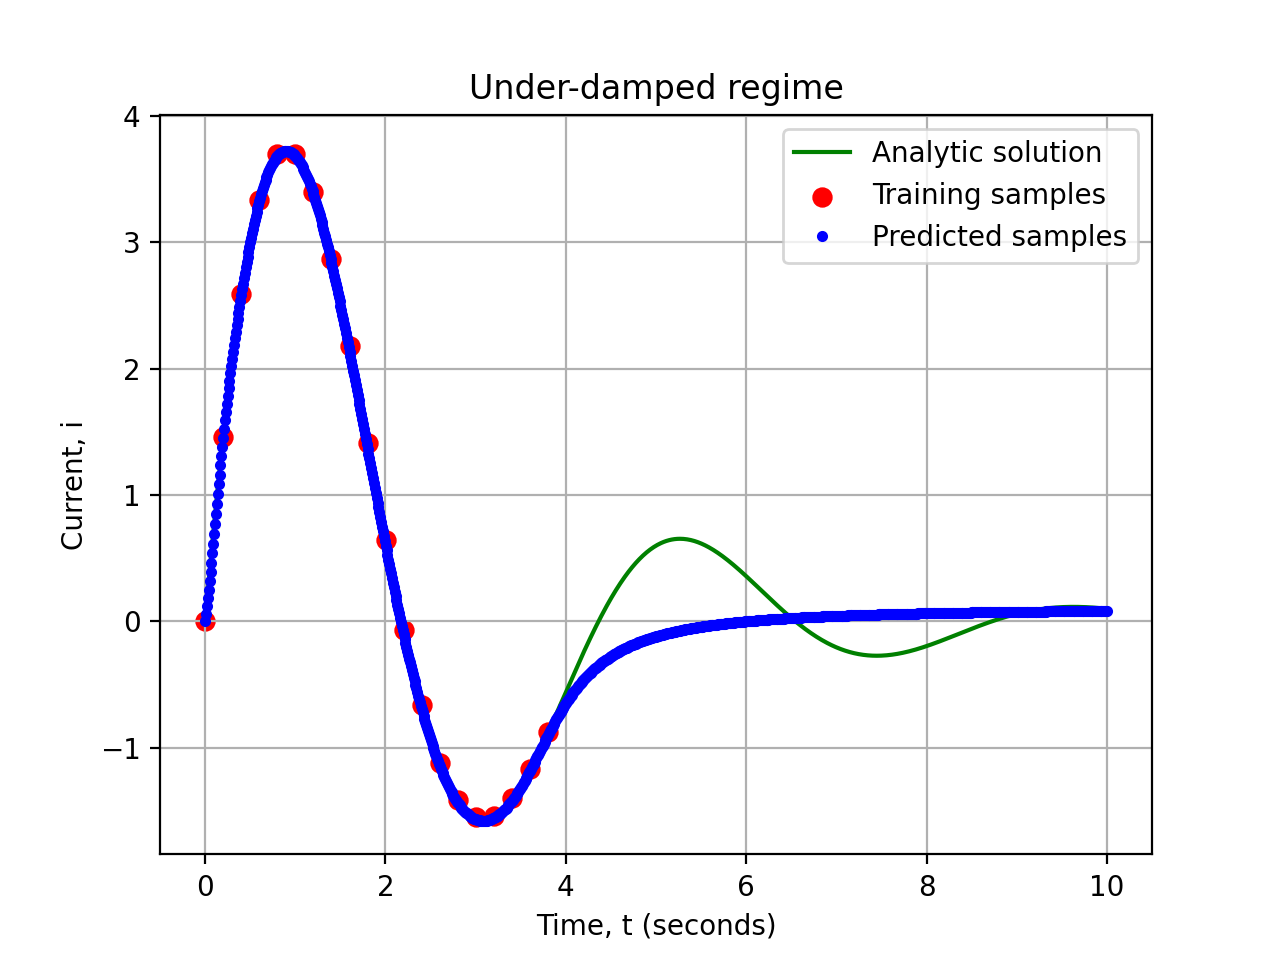

<IPython.core.display.Javascript object>


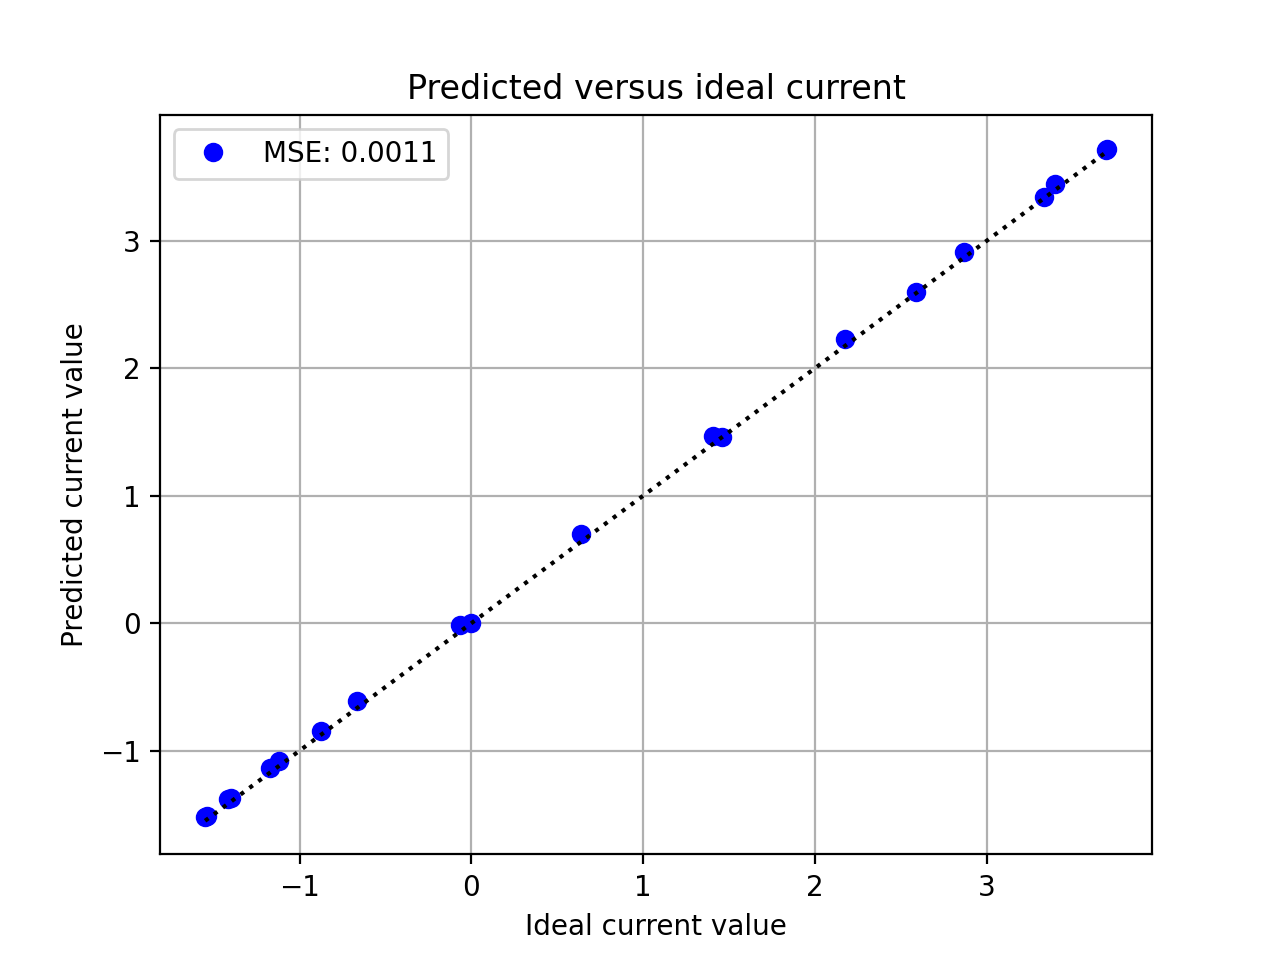

In [267]:
# Here, plot the full analytical solution, the samples used for training, and the prediction over all time.

plt.figure()
plt.plot(t, model_i, "g-", label="Analytic solution")
plt.scatter(t_data, i_data, s=40, color="red", label='Training samples')
plt.plot(t, ifull, "b.", label="Predicted samples")

plt.xlabel('Time, t (seconds)')
plt.ylabel('Current, i')
plt.title(regime)
plt.grid()
plt.legend()
plt.show()

# Here is the MSE between the training and predicted current values:
error = torch.mean(i_data-ih.detach())**2

# Plot predicted versus ideal samples
plt.figure()
plt.plot(i_data, ih.detach(), "bo", label = f'MSE: {np.round(error.item(),5)}')
# Here is the 1:1 regression for a visual reference:
plt.plot([torch.min(i_data).item(), torch.max(i_data).item()], 
         [torch.min(i_data).item(), torch.max(i_data).item()], "k:")
plt.xlabel('Ideal current value')
plt.ylabel('Predicted current value')
plt.legend()
plt.title('Predicted versus ideal current')
plt.grid()
plt.show();

## PINN

> Here, we add the differential equation and the two initial conditions to the losses. 

The physics loss ensures the learned solution is consistent with the underlying differential equation. This is done by penalising the residual of the differential equation over a set of locations sampled from the domain.  

Here we evaluate the physics loss at 100 points uniformly spaced over the entire time domain $([0,10])$. We can calculate the derivatives of the network solution with respect to its input variable at these points using `pytorch`'s autodifferentiation features, and can then easily compute the residual of the differential equation using these quantities. 


In [272]:
# Make a time vector of N points over the entire domain, reshape it, 
# and enable gradient tracking. N should be at least 50 (?)
# The view(-1, 1) method makes t_physics an N x 1 vector

N_pts = 50
t_physics = torch.linspace(time_start, time_stop, N_pts).view(-1, 1).requires_grad_(True) 

torch.manual_seed(123)
# Specify number of hidden layers and neurons per layer in the network:
model = FCN(1, 1, 68, 5)  # FCN(1, 1, 32, 3)
epochs = 5000
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
data_loader = DataLoader(t_physics, batch_size=N_pts, drop_last=False, shuffle=True)

# Initialize variables to hold the various losses versus the epoch number
loss1_all, loss2_all, loss3_all, loss4_all, total_loss = [], [], [], [], []

for _ in range(epochs):
    
    optimizer.zero_grad()

     # Here is the prediction of training data points from the analytic solution
    yh = model(t_data)
    # Loss is computed from the true analytic values (i_data) and the model predictions (yh)
    loss1 = torch.mean((yh-i_data)**2) # use mean squared error
    loss1_all = np.append(loss1_all, loss1.item())
    
    # Here, compute the "physics loss" over the entire time interval, t_physics
    
    # 1) Compute the loss from the from the homogeneous solution (no ICs) of the ODE
    ihp = model(t_physics) # Estimate the predicted current over all time
    di  = torch.autograd.grad(ihp, t_physics, torch.ones_like(ihp), create_graph=True)[0] # computes di/dt
    di2 = torch.autograd.grad(di,  t_physics, torch.ones_like(di),  create_graph=True)[0] # computes d^2i/dt^2
    physics = L*di2 + R*di + ihp/C # Homogeneous ODE for RLC series circuit
    loss2 = (5.0)*torch.mean(physics**2)   # Default: (1e-4)
    loss2_all = np.append(loss2_all, loss2.item())
    
    # Compute the "physics loss" from the particular solution (ICs)
    # 2) Here is the initial condition i[0] = 0:
    loss3 = (1.0)*ihp[0]**2
    loss3_all = np.append(loss3_all, loss3.item())
    
    # 3) Here is the initial condition di/dt = V0/L at t = 0:
    loss4 = (di[0] - V0/L)**2
    loss4_all = np.append(loss4_all, loss4.item())

    # Backpropagate the joint loss and update the weights
    loss = loss1 + loss2 + loss3 + loss4 # add the loss terms together
    total_loss = np.append(total_loss, loss.item())
    loss.backward()   # Back propagate
    optimizer.step()  # Update weights

    yh = model(t_physics).detach()  # This is the final prediction over all time
    tp = t_physics.detach()


### Compare the PINN results with the analytic solution over the entire time domain

<IPython.core.display.Javascript object>


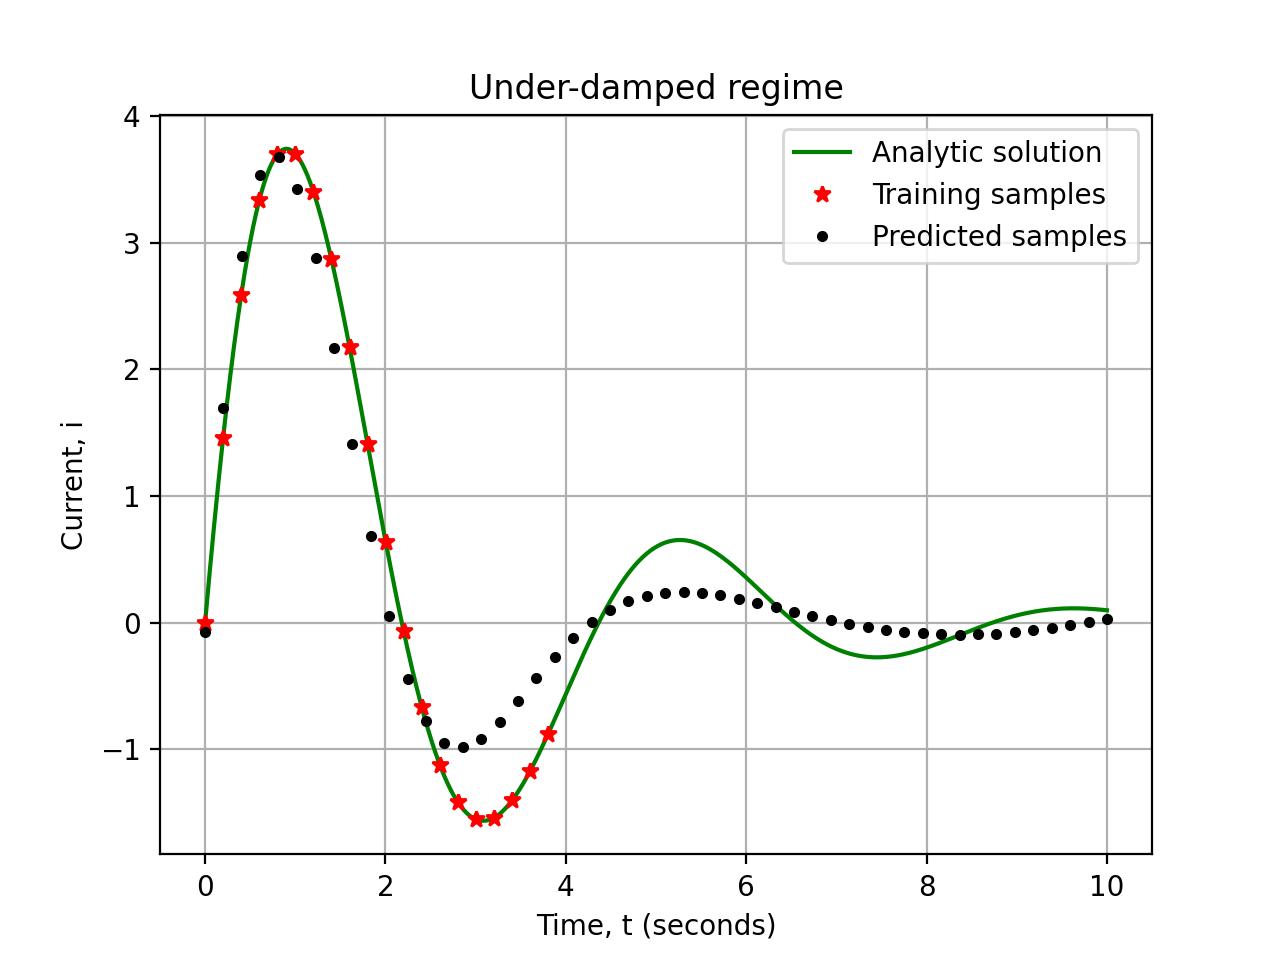

In [273]:
plt.figure()
plt.plot(t, model_i, "g-", label="Analytic solution")
plt.plot(t_data, i_data, "r*", label="Training samples")
plt.plot(tp, yh, "k.", label="Predicted samples")

plt.xlabel('Time, t (seconds)')
plt.ylabel('Current, i')
plt.title(regime)
plt.grid()
plt.legend()
plt.show()


### Here we plot all the losses versus epoch number on both log and linear scales.

<IPython.core.display.Javascript object>


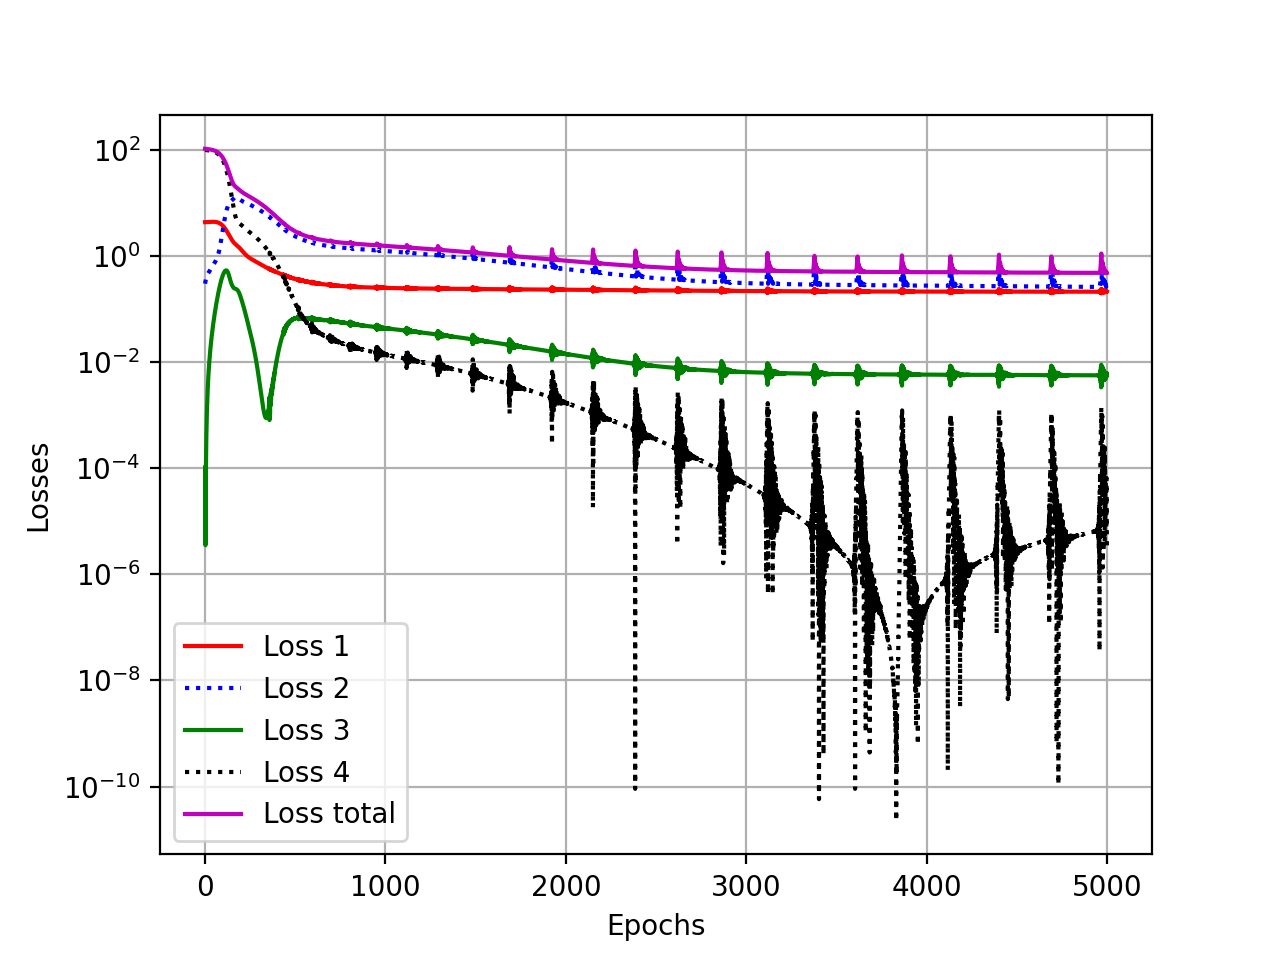

<IPython.core.display.Javascript object>


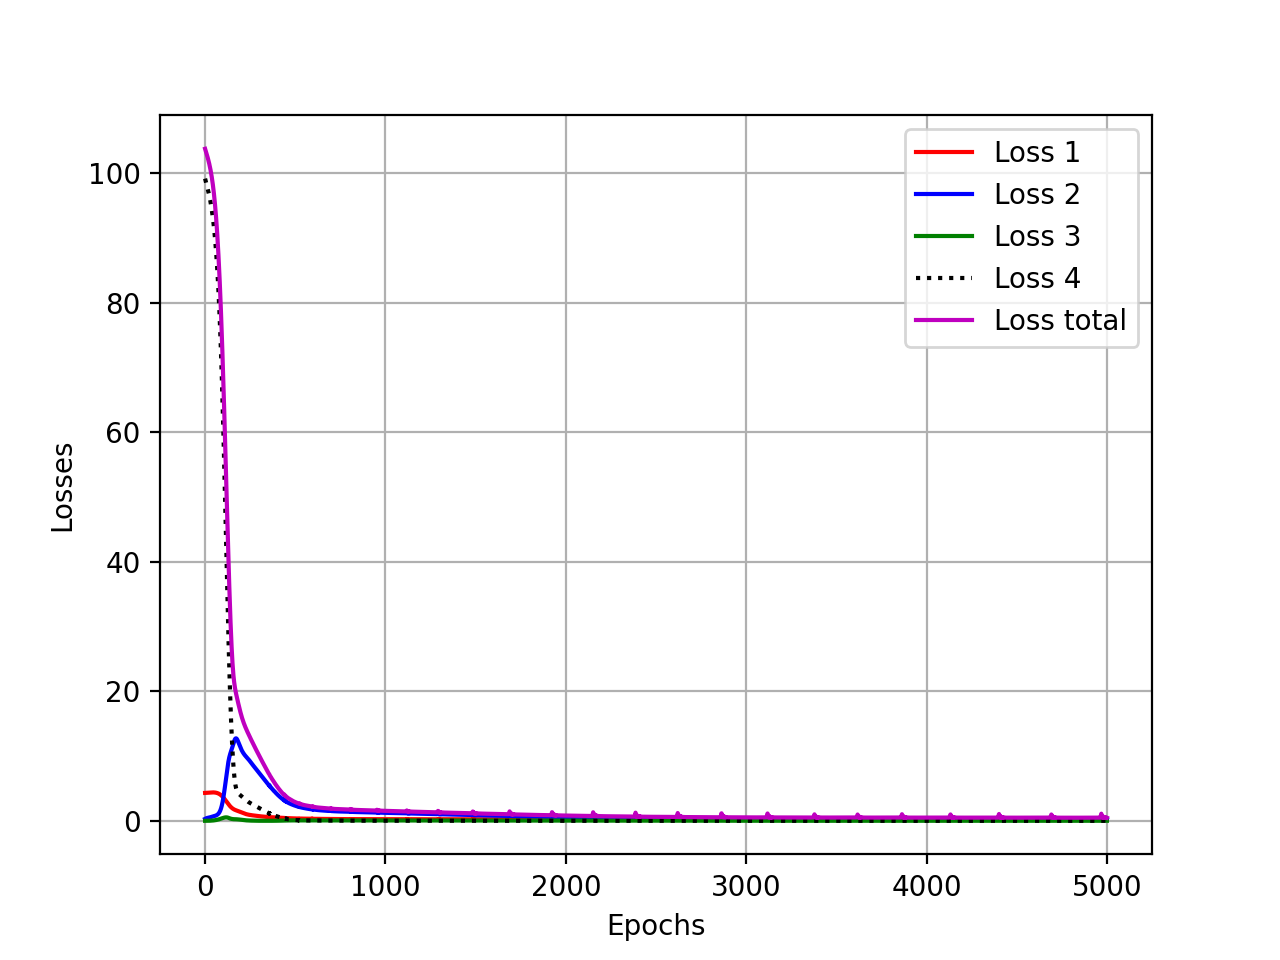

In [274]:
plt.figure()
plt.semilogy(loss1_all, "r-", label = "Loss 1")
plt.semilogy(loss2_all, "b:", label = "Loss 2")

plt.semilogy(loss3_all, "g-", label = "Loss 3")
plt.semilogy(loss4_all, "k:", label = "Loss 4")

plt.semilogy(total_loss, "m-", label = "Loss total")

plt.xlabel("Epochs")
plt.ylabel("Losses")

plt.grid()
plt.legend()
plt.show()


plt.figure()
plt.plot(loss1_all, "r-", label = "Loss 1")
plt.plot(loss2_all, "b-", label = "Loss 2")

plt.plot(loss3_all, "g-", label = "Loss 3")
plt.plot(loss4_all, "k:", label = "Loss 4")

plt.plot(total_loss, "m-", label = "Loss total")

plt.xlabel("Epochs")
plt.ylabel("Losses")

plt.grid()
plt.legend()
plt.show()

In [284]:
data_loader.dataset.nextafter(t_physics)

tensor([[ 0.0000],
        [ 0.2041],
        [ 0.4082],
        [ 0.6122],
        [ 0.8163],
        [ 1.0204],
        [ 1.2245],
        [ 1.4286],
        [ 1.6327],
        [ 1.8367],
        [ 2.0408],
        [ 2.2449],
        [ 2.4490],
        [ 2.6531],
        [ 2.8571],
        [ 3.0612],
        [ 3.2653],
        [ 3.4694],
        [ 3.6735],
        [ 3.8776],
        [ 4.0816],
        [ 4.2857],
        [ 4.4898],
        [ 4.6939],
        [ 4.8980],
        [ 5.1020],
        [ 5.3061],
        [ 5.5102],
        [ 5.7143],
        [ 5.9184],
        [ 6.1224],
        [ 6.3265],
        [ 6.5306],
        [ 6.7347],
        [ 6.9388],
        [ 7.1429],
        [ 7.3469],
        [ 7.5510],
        [ 7.7551],
        [ 7.9592],
        [ 8.1633],
        [ 8.3673],
        [ 8.5714],
        [ 8.7755],
        [ 8.9796],
        [ 9.1837],
        [ 9.3878],
        [ 9.5918],
        [ 9.7959],
        [10.0000]], grad_fn=<NextafterBackward0>)